Pima indians diabetes analysis
============================

In [1]:
# Numerical libs
import numpy as np
import pandas as pd
# Definindo os algarismos significativos a serem apresentados nas tabelas.
pd.options.display.float_format = '{:.3f}'.format  

# Plot libs 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## 1. Loading data file

In [2]:
dataset = pd.read_csv('data/diabetes.csv')

The variable names for the columns are as follows:

* 0. Number of times pregnant
* 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* 2. Diastolic blood pressure (mm Hg)
* 3. Triceps skin fold thickness (mm)
* 4. 2-Hour serum insulin (mu U/ml)
* 5. Body mass index (weight in kg/(height in m)^2)
* 6. Diabetes pedigree function
* 7. Age (years)
* 8. Class variable: diabetes - not sick or sick (0 or 1)

In [3]:
dataset.sample(8)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.300,0.134,29,0
281,10,129,76,28,122,35.900,0.280,39,0
624,2,108,64,0,0,30.800,0.158,21,0
264,4,123,62,0,0,32.000,0.226,35,1
702,1,168,88,29,0,35.000,0.905,52,1
572,3,111,58,31,44,29.500,0.430,22,0
206,8,196,76,29,280,37.500,0.605,57,1
387,8,105,100,36,0,43.300,0.239,45,1


Let's change the labels so we can easily remember their meaning.

In [4]:
# Alterando o nome das colunas
names = ['pregnancies', 'glucose', 'diastolic', 'thickness', 'insulin', 'bmi', 'dpf', 'age', 'diabetes']
dataset.columns = names
dataset.head()

,pregnancies,glucose,diastolic,thickness,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## 2. Exploratory Data Analysis (EDA)

Let's check the size of dataframe.

In [5]:
print("Dataset size: ",dataset.shape)

Dataset size:  (768, 9)


Check the number of different values on each column.

In [6]:
dataset.nunique()

pregnancies     17
glucose        136
diastolic       47
thickness       51
insulin        186
bmi            248
dpf            517
age             52
diabetes         2
dtype: int64

Command `.info` tell us the total number of non null observations present including the total number of entries. Once number of entries isn’t equal to number of non null observations, we can begin to suspect missing values.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies    768 non-null int64
glucose        768 non-null int64
diastolic      768 non-null int64
thickness      768 non-null int64
insulin        768 non-null int64
bmi            768 non-null float64
dpf            768 non-null float64
age            768 non-null int64
diabetes       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Since all the columns match with entries, we can ensure that there are no missing number (NaN). Even so, we can count the number of NaN in each column with `.isnull()` and `.sum()` to identify a null entry.

In [8]:
dataset.isnull().sum()

pregnancies    0
glucose        0
diastolic      0
thickness      0
insulin        0
bmi            0
dpf            0
age            0
diabetes       0
dtype: int64

which confirms that all fields were filled.

Method `.describe()` will display a summary statistics of all observed features and labels. The most important to note here is the min value. Once we see -1/0 in an observation like age/height/weight/bmi, then we have been able to detect invalid values.

In [9]:
dataset.describe()

,pregnancies,glucose,diastolic,thickness,insulin,bmi,dpf,age,diabetes
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


We can see that columns 2 to 5 have invalid data. Data filled with zero does not make sense and indicates a replacement for missing value.

Excluding `Pregnancies` and `diabetes`, for which number zero is a possible value, we can count the total number of zeros used to replace a NaN for each columns. 

In [10]:
(dataset.drop(['pregnancies','diabetes'], axis=1) == 0).sum()

glucose        5
diastolic     35
thickness    227
insulin      374
bmi           11
dpf            0
age            0
dtype: int64

The following columns have an invalid value:

1: Plasma glucose concentration; 2: Diastolic blood pressure; 3: Triceps skinfold thickness; 4: 2-Hour serum insulin; 5: Body mass index


It is important to know the percentage of invalid values for each column, so we can evaluate if the column can be discarded or not. 

If missing values for each column reach percentage close to 90%,  the information will surely not help us to classify the data, therefore the entire column can be removed.
On the other hand, when few rows have missing values, less than 0.5% (as a rule of thumb), those rows can be disregarded.

## 3. Treating missing values

### Target analysis:

To check the fraction of people sick or healthy in data set.

In [11]:
n_health, n_sick = np.array([(dataset[['diabetes']] == 0).sum(), 
                             (dataset[['diabetes']] == 1).sum()]) / dataset.shape[0] * 100

Percentage of healthy is 65.10% and 34.90% are sick.


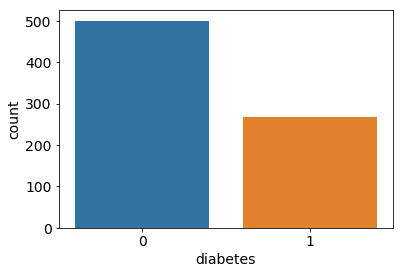

In [12]:
print('Percentage of healthy is {:.2f}% and {:.2f}% are sick.'.format(n_health[0],n_sick[0]))
plt.rc('font',size=14)
sns.countplot(x='diabetes', data=dataset);

### Checking for linear correlations.

In [13]:
# Pearson correlation: 
dataset.corr()

,pregnancies,glucose,diastolic,thickness,insulin,bmi,dpf,age,diabetes
pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
diastolic,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
thickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
bmi,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
dpf,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
diabetes,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


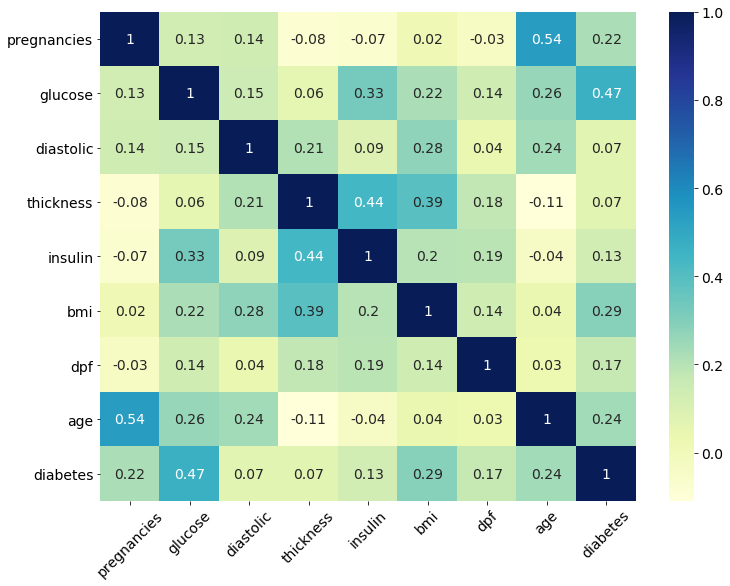

In [14]:
cor_matrix = dataset.corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(12,9));
plt.rc('font',size=14)
sns.heatmap(cor_matrix, annot=True, cmap="YlGnBu");
plt.yticks(rotation=0); plt.xticks(rotation=45);

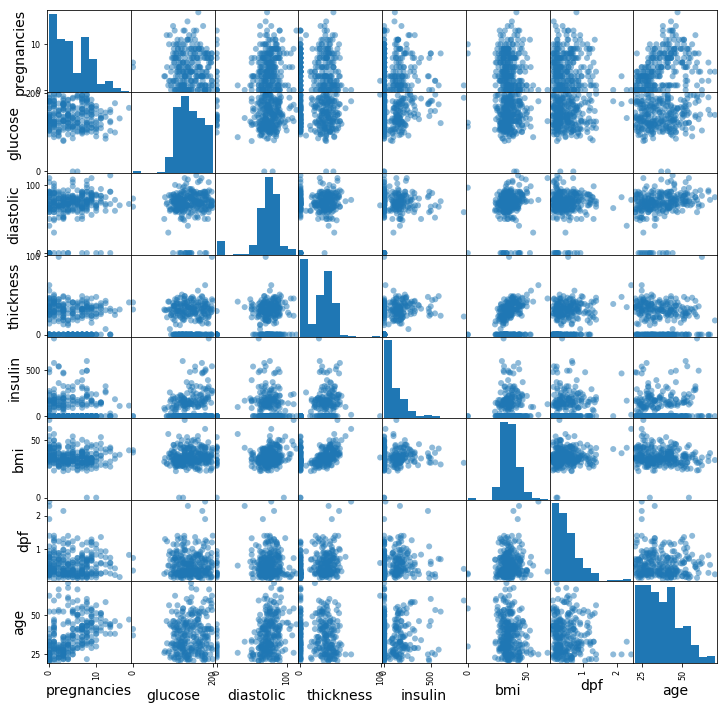

In [15]:
df_ptos = dataset[dataset['diabetes'] == 1].loc[:,['pregnancies', 'glucose', 'diastolic', 
                                                   'thickness', 'insulin', 'bmi', 'dpf', 'age']]
pd.plotting.scatter_matrix(df_ptos, figsize=(12,12), marker='o');